# Deep Learning for Computer Vision:  Assignment 2


## Computer Science: COMS W 4995 004


### Due: February 16, 2017

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu or leaky ReLu. For the loss function use a sigmoid on a linear output layer. 

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512

If you are struggling to get the network to converge, experiment with different learning rates.



Let's start by importing some libraries.

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

Let's make up some noisy XOR data.

In [3]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,1.200567,0.792003,0.0
1,0.171255,-0.022330,0.0
2,-0.094400,0.150070,0.0
3,1.227653,-0.043778,1.0
4,0.816040,0.924116,0.0


Let's message this data into a numpy format.

In [4]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [5]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

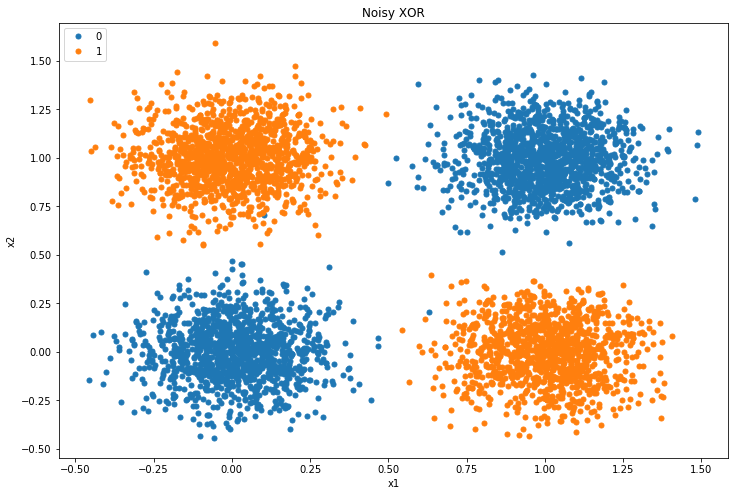

In [6]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

In [139]:
def softplus(x):
    return np.log(1 + np.exp(x))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def max_zero(x):
    return max(0, x)

def f_relu(x):
    return 0 if x <= 0 else 1

max_zero_vector = np.vectorize(max_zero)
f_relu_vector = np.vectorize(f_relu)

def hidden_layer_forward(x, W, c):
    u_1 = np.inner(W.T, x)
    u_2 = u_1 + c
    return (max_zero_vector(u_2), u_1, u_2)

def hidden_layer_backward(gL_h, x):
    gL_c = f_relu_vector(gL_h)
    gL_W = x.T * gL_c.T
    # TODO: Not sure how to implement this.
    return (gL_c,gL_W)
    
def output_layer_forward(h, w, b):
    u_3 = np.dot(w.T, h)
    return (u_3 + b, u_3)

def output_layer_backward(dL_dz, h, w):
    dL_db = dL_dz
    dL_dw = dL_dz * h
    gL_h = dL_dz * w
    return (dL_db, dL_dw, gL_h)
    
def loss_layer_forward(z, y):
    u_4 = (1 - (2 * y)) * z
    return (softplus(u_4), u_4)
    
def loss_layer_backward(u_4, y):
    dL_dz = (sigmoid(u_4)[0,0] * (1 - (2 * y)))[0,0]
    return dL_dz
    
def forward_propagation(x, y, W, c, w, b):
    (h, u_1, u_2) = hidden_layer_forward(x, W, c)
    (z, u_3) = output_layer_forward(h, w, b)
    (L, u_4) = loss_layer_forward(z, y)
    return (h, z, L, u_1, u_2, u_3, u_4)

def back_propagation(forward_results, x, y, w):
    (h, z, L, u_1, u_2, u_3, u_4) = forward_results
    dL_dz = loss_layer_backward(u_4, y)
    (dL_db, dL_dw, gL_h) = output_layer_backward(dL_dz, h, w)
    (gL_c, gL_W) = hidden_layer_backward(gL_h, x)
    return (gL_c, gL_W, dL_dw, dL_db)

In [146]:
def batch_gradient_descent(X, y, params, batch_size, num_iters, learn_rate):
    # Go through num_iters iterations
    (W, c_t, w_t, b_t) = params
    cum_loss = 0.0
    iteration = 0
    while iteration < num_iters:
        cum_loss = 0.0
        print cum_loss
        print 'Iteration ' + str(iteration)
        # Break up the data into batches
        for j in range(0, X.shape[0] / batch_size):
            W_j = np.zeros((2,2))
            c_j = np.zeros((2,1))
            w_j = np.zeros((2,1))
            b_j = 0.0
            for k in range(0, batch_size):
                sample_x = X[(j * batch_size) + k]
                sample_y = y[(j * batch_size) + k]
                forward_results = forward_propagation(sample_x, sample_y, W, c, w, b)
                (gL_c, gL_W, dL_dw, dL_db) = back_propagation(forward_results, sample_x, sample_y, w)
                W_j = np.add(W_j, gL_W)
                c_j = np.add(c_j, gL_c)
                w_j = np.add(w_j, dL_dw)
                b_j = b_j + dL_db
                
                L = forward_results[2]
                cum_loss += L
            W = W - ((learn_rate) * ((1 / float(batch_size)) * W_j))
            c_t = c_t - ((learn_rate) * ((1 / float(batch_size)) * c_j))
            w_t = w_t - ((learn_rate) * ((1 / float(batch_size)) * w_j))
            b_t = b_t - ((learn_rate) * ((1 / float(batch_size)) * b_j))
        print cum_loss
        iteration += 1
    return (W, c, w, b)

In [147]:
W = np.random.rand(2,2)
c = np.random.rand(2,1)
w = np.random.rand(2,1)
b = np.random.random()
params = (W, c, w, b)

batch_size = 10
num_iters = 10
learn_rate = 0.1

param_results = batch_gradient_descent(X, y, params, batch_size, num_iters, learn_rate)

0.0
Iteration 0
[[ 4146.61344106]]
0.0
Iteration 1
[[ 4753.83681453]]
0.0
Iteration 2
[[ 5430.82092802]]
0.0
Iteration 3
[[ 6122.85402693]]
0.0
Iteration 4
[[ 6820.78914296]]
0.0
Iteration 5
[[ 7521.66862677]]
0.0
Iteration 6
[[ 8224.22717305]]
0.0
Iteration 7
[[ 8927.75025524]]
0.0
Iteration 8
[[ 9631.90444514]]
0.0
Iteration 9
[[ 10336.47333094]]
